# Import Packages

In [2]:
import sys
import os


PATH_results_npz = '/home/ardhuin/PUBLI/2024_De_Carlo_Ardhuin/SIMULATIONS/RESULTS/'
# Note that these result files are available in this dataset: 
# https://www.seanoe.org/data/00868/97944/

import glob
import scipy as scipy
import xarray as xr
import numpy as np

from wave_physics_functions import wavespec_Efth_to_Ekxky,wavespec_MEM,wavespec_Efth_to_first3

from matplotlib.dates import DateFormatter
# --- plotting and interactive stuff ----------------------
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.signal import fftconvolve

cNorm = mcolors.Normalize(vmin=0, vmax=2)
jet = plt.get_cmap('jet')
mpl.rcParams.update({'figure.figsize':[10,6],'axes.grid' : True,'font.size': 14,'savefig.facecolor':'white'})

cmap0 = 'viridis'

# Prepare all

NpzFile 'HQ_table_loopspeckle.npz' with keys: tableQ
tableQ = data["tableQ"]
find: [1.]


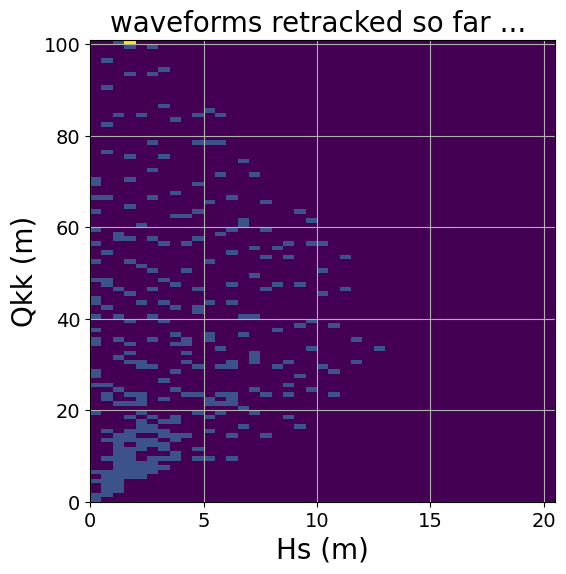

In [3]:
filetr='/home/ardhuin/PUBLI/2024_SWELLSWOT/SWOT_WW3-GLOB-30M_202306_trck.nc'
# NB: this file is available here:  https://www.seanoe.org/data/00886/99783/data/109894.nc
# as part of this dataset:  https://www.seanoe.org/data/00886/99783/


ds_ww3t = xr.open_dataset(filetr)
modang=np.mod(90-ds_ww3t.direction,360)
modnth=np.shape(modang)[0]
moddth=(2*np.pi/modnth)
#print(ds_ww3t)
#print(ds_ww3t.track_name[0])
#print(np.min(ds_ww3t.longitude[:]))

nH=41;dH=0.5
nQ=101;dQ=1.
Qs=np.linspace(0,(nQ-1)*dQ,nQ)+dQ/2
Hs=np.linspace(0,(nH-1)*dH,nH)+dH/2


data=np.load('HQ_table_loopspeckle.npz',allow_pickle=True)
#data=np.load('HQ_table_loopnonoise.npz',allow_pickle=True)
print(data)
for k in data.keys():
    print(k+' = data["'+k+'"]')
    exec(k+' = data["'+k+'"]')
print('find:',tableQ[1,23,0:1])

fig,ax=plt.subplots(figsize=(6,6))
map=tableQ[:,:,0]
im=ax.pcolormesh(Hs,Qs,map.T, rasterized=True)
ax.set_xlabel('Hs (m)', fontsize=20)
ax.set_ylabel('Qkk (m)' , fontsize=20)
ax.set_title('waveforms retracked so far ... ' , fontsize=20)


indtable=tableQ[:,:,1].flatten()

filtable=tableQ[:,:,0].flatten()
Hstable=tableQ[:,:,5].flatten()

In [4]:
#filelist=sorted(glob.glob('/home/ardhuin/PUBLI/2024_XBAND/20230413_13/MIR_20230413_14*', recursive=True)) 

bigtab=np.zeros((260,12,2,2))
bigtab2=np.zeros((260,12,2,2))
ind=0
WW3t='WW3t';nameSat='CFOSAT'
#indtable=np.arange(155,455,10)
#indtab=(indtable[filtable > 0. and Hstable > 1.]).astype(int)
indtab=(indtable[Hstable > 0.7]).astype(int)
nind=len(indtab)
print('inds:',indtab)
navg=20   # Added by FA, 23/02/2024
navg2=10
filteravg=np.zeros((navg2*2+1))+1./(navg2*2+1)
nH=41;dH=0.5
nQ=71;dQ=1.

for inds in indtab:
    indss=f'{abs(inds):07d}'
    
    modspec=ds_ww3t.efth[inds].squeeze()
    moddf=ds_ww3t.frequency2.values-ds_ww3t.frequency1.values
    modf=ds_ww3t.frequency.values
    [modEf,modth1,modsth1,Hs,Tm0m1,Qf,Qkk]=wavespec_Efth_to_first3(modspec.values,modf,moddf, modang.values,moddth)
    iQ=int(Qkk/dQ)
    iH=int(Hs/dH) 
    
    bigtab[ind,0:4,0,0]=[Hs,Tm0m1,Qf,Qkk]
    
    for noisetag in [ 'nonoise','speckle']:
#    for noisetag in [ 'nonoise']:
        noise=0
        if noisetag == 'speckle':
            noise=1
        file1=PATH_results_npz+'Hs_ze_retrack_'+WW3t+'_ind'+indss+'_3par_NMLS_'+noisetag+'_'+nameSat+'.npz'
        if os.path.isfile(file1):
            data=np.load(file1,allow_pickle=True)
            for k in data.keys():
               exec(k+' = data["'+k+'"]')
            Hs2=Hs_retrack
            ze2=ze
            Pu2=Pu

            data=np.load(PATH_results_npz+'Hs_ze_retrack_'+WW3t+'_ind'+indss+'_3par_NMML_'+noisetag+'_'+nameSat+'.npz',allow_pickle=True)
            for k in data.keys():
               exec(k+' = data["'+k+'"]')
            Hs1=Hs_retrack
            ze1=ze
            Pu1=Pu
    #print(np.round([np.std(Hs1),np.sqrt(np.mean(Hs1*Hs1)),np.mean(ze1),np.std(ze1)],2)) # np.std(Hs2),np.mean(Hs1),np.mean(Hs2)],2))
    #print(np.round([np.std(Hs2),np.sqrt(np.mean(Hs2*Hs2)),np.mean(ze2),np.std(ze2)],2)) # np.std(Hs2),np.mean(Hs1),np.mean(Hs2)],2))
    #print('index:',indss)
    #print(noisetag+" & ML & %.2f &  %.2f & %.3f & %.2f \\\ " % (np.sqrt(np.mean(Hs1*Hs1)),np.std(Hs1) ,np.mean(ze1),np.std(ze1)) )
    #print("        & LS & %.2f &  %.2f & %.3f & %.2f \\\ " % (np.sqrt(np.mean(Hs2*Hs2)),np.std(Hs2) ,np.mean(ze2),np.std(ze2)) )
            if noise == 0:
               print('inds:',inds,ind,nind,indss,iH,iQ,Hs,np.std(Hs2)) 

            bigtab[ind,4:10,0,noise]=[np.sqrt(np.mean(Hs1*Hs1)),np.std(Hs1) ,np.mean(ze1),np.std(ze1),np.mean(Pu1),np.std(Pu1)]
            bigtab[ind,11,0,noise]=np.std(np.mean(Hs1[0:navg,:],axis=0))
            bigtab[ind,4:10,1,noise]=[np.sqrt(np.mean(Hs2*Hs2)),np.std(Hs2) ,np.mean(ze2),np.std(ze2),np.mean(Pu2),np.std(Pu2)]
            bigtab[ind,11,1,noise]=np.std(np.mean(Hs2[0:navg,:],axis=0))
            [nx,ny]=np.shape(Hs1)
            Hs1f=np.zeros((nx-navg2*2,ny))
            Hs2f=np.zeros((nx-navg2*2,ny))
            #ze1f=Hs1f
            #ze2f=Hs1f
            for iy in range(ny):
                line=fftconvolve(Hs1[:,iy],filteravg,mode='same')
                Hs1f[:,iy]=line[navg2:nx-navg2]
                line=fftconvolve(Hs2[:,iy],filteravg,mode='same')
                Hs2f[:,iy]=line[navg2:nx-navg2]
                #line=fftconvolve(ze1[:,iy],filteravg,mode='same')
                #ze1f[:,iy]=line[navg2:nx-navg2]
                #line=fftconvolve(ze2[:,iy],filteravg,mode='same')
                #ze2f[:,iy]=line[navg2:nx-navg2]
            bigtab2[ind,4:10,0,noise]=[np.sqrt(np.mean(Hs1f*Hs1f)),np.std(Hs1f) ,np.mean(ze1),np.std(ze1),np.mean(Pu1),np.std(Pu1)]
            bigtab2[ind,11,0,noise]=np.std(np.mean(Hs1f[0:navg,:],axis=0))
            bigtab2[ind,4:10,1,noise]=[np.sqrt(np.mean(Hs2f*Hs2f)),np.std(Hs2f) ,np.mean(ze2),np.std(ze2),np.mean(Pu2),np.std(Pu2)]
            bigtab2[ind,11,1,noise]=np.std(np.mean(Hs2f[0:navg,:],axis=0))
        else:
            print('MISSING FILE:',indss,iH,iQ,file1) 
    ind = ind+1




inds: [1013475 1128408 1524104  377466  346311  377616  110031   74774 1300705
  808380  806717   50088  570579   77636 1624733  460439   46360  188527
 1715561  537075  455296  555185  476641  506842  254035  436801  676500
  658958 1197799  148628  350744  526238 1152555  547547  306023   37788
  735514 1121494  989556  574747 1464133 1095139 1094218 1193784 1503780
  462798  361468 1323138  849930  526292  435139 1075954  120327  964673
  903811  350773  350776  554053  710796   57387  845956 1680809  775979
 1497394  939186 1309516 1679020  102977 1506564  104559  548649  388313
 1018524  163984   41543 1453621 1290921  980464  338981  221735 1704488
   53427 1168668 1194020  660846  840186 1676097  166393 1621722    5084
  271439 1637422  956769  257397   25265 1402940  258305  317186  680021
  680061 1506312  253241  276611  894182  354653  223266 1535654 1084720
 1489463  924114 1230463  999605 1356480 1636468  619627  621973 1616784
 1025248  322202  671368  890739  733582  147

## simple plots

In [ ]:
small=6
fig,ax1=plt.subplots(1,1,figsize=(8,5))
vecHs=np.linspace(1,12,23)
ax1.plot(vecHs,vecHs**1*5/264,c='black',linewidth=3,label=r'eq. (23), n=1, $s_0=5$~m.');
ax1.plot(vecHs,vecHs**1*1/264,c='black',linewidth=3,linestyle='dashed',label=r'eq. (23), n=1, $s_0=1$~m.');
ax1.scatter(bigtab[:,0,0,0],bigtab[:,5,1,1]**2-bigtab[:,5,1,0]**2,c='red',s=small,label='LS');
ax1.scatter(bigtab[:,0,0,0],bigtab[:,5,0,1]**2-bigtab[:,5,0,0]**2,c='blue',s=small,label='ML');
#ax1.plot(vecHs,vecHs**0/700+vecHs**1/600,c='black',linewidth=3,linestyle='dashed',label='ML');
ax1.set_xlabel('$H_s$ (m)')
ax1.set_title(r'(e)  var($\widehat{H}_s$) with noise - var($\widehat{H}_s$) without noise, m$^2$')
leg = ax1.legend(loc='upper left', fontsize=16)
fig.savefig('speckle_only.pdf')

In [ ]:
fig,axs=plt.subplots(4,2,figsize=(13,16))
Qvec=np.linspace(0,60,61)
alti_sat=519000
std1=4.2*Qvec/np.sqrt(alti_sat)
var1=(4.2*Qvec/np.sqrt(alti_sat))**2

ind1=np.where(bigtab[:,0,0,0] < 2 )[0]
ind2=np.where(bigtab[:,0,0,0] > 2)[0]
small=5

#fig,ax=plt.subplots(1,2,figsize=(12,4))
ax2=axs[0,:]
p=1.
ax2[0].scatter(bigtab[ind1,3,0,0],bigtab[ind1,7,0,0]/bigtab[ind1,0,0,0]**p,c='blue',s=small);
ax2[0].scatter(bigtab[ind1,3,0,0],bigtab[ind1,7,1,0]/bigtab[ind1,0,0,0]**p,c='red',s=small);
ax2[0].scatter(bigtab[ind2,3,0,0],bigtab[ind2,7,0,0]/bigtab[ind2,0,0,0]**p,c='blue',s=30,label='ML');
ax2[0].scatter(bigtab[ind2,3,0,0],bigtab[ind2,7,1,0]/bigtab[ind2,0,0,0]**p,c='red',s=20,label='LS');
ax2[0].set_xlabel('$Q_{kk}$ (m)')
ax2[0].set_ylabel('std($\widehat{z}_e$)/${H_s}$ ')
ax2[0].set_title('(a) without noise')

ax2[0].set_ylim([0,0.03])



ax2[1].scatter(bigtab[ind1,3,0,0],bigtab[ind1,7,0,1]/bigtab[ind1,0,0,0]**p,c='blue',s=small);
ax2[1].scatter(bigtab[ind1,3,0,0],bigtab[ind1,7,1,1]/bigtab[ind1,0,0,0]**p,c='red',s=small);
ax2[1].scatter(bigtab[ind2,3,0,0],bigtab[ind2,7,0,1]/bigtab[ind2,0,0,0]**p,c='blue',s=30,label='ML');
ax2[1].scatter(bigtab[ind2,3,0,0],bigtab[ind2,7,1,1]/bigtab[ind2,0,0,0]**p,c='red',s=20,label='LS');
ax2[1].set_xlabel('$Q_{kk}$ (m)')
ax2[1].set_ylabel('std($\widehat{z}_e$)/${H_s}$')
leg = ax2[0].legend(loc='upper left', fontsize=16)
ax2[1].set_title('(e) with speckle noise')
ax2[1].set_ylim([0,0.03])

plt.tight_layout()
#fig.savefig('allspec_stdetavsHs.pdf')


########################################################
ax=axs[1,:]
ax[0].scatter(bigtab[ind1,0,0,0],bigtab[ind1,5,0,0],c='blue',s=small);
ax[0].scatter(bigtab[ind1,0,0,0],bigtab[ind1,5,1,0],c='red',s=small);
ax[0].scatter(bigtab[ind2,0,0,0],bigtab[ind2,5,0,0],c='blue',s=30,label='ML');
ax[0].scatter(bigtab[ind2,0,0,0],bigtab[ind2,5,1,0],c='red',s=20,label='LS');
ax[0].set_xlabel('$Q_{kk}$ (m)')
ax[0].set_xlabel('$H_s$ (m)')
ax[0].set_ylabel('std($\widehat{H}_s$) (m)')
ax[0].set_title('(b) without noise')
#ax[0].set_xlim(0.0, 12)
ax[0].set_ylim(0.0, 1.3)
leg = ax[0].legend(loc='upper left', fontsize=16)

ax[1].scatter(bigtab[ind1,0,0,0],bigtab[ind1,5,0,1],c='blue',s=small);
ax[1].scatter(bigtab[ind1,0,0,0],bigtab[ind1,5,1,1],c='red',s=small);
ax[1].scatter(bigtab[ind2,0,0,0],bigtab[ind2,5,0,1],c='blue',s=30,label='ML');
ax[1].scatter(bigtab[ind2,0,0,0],bigtab[ind2,5,1,1],c='red',s=20,label='LS');
ax[1].set_xlabel('$H_s$ (m)')
ax[1].set_ylabel('std($\widehat{H}_s$) (m)')
ax[1].set_title('(f) with speckle noise')
#ax[1].set_xlim(0.0, 12)
ax[1].set_ylim(0.0, 1.3)
#fig.savefig('allspec_stdHsvsHs.pdf')


########################################################
#fig,ax=plt.subplots(1,2,figsize=(12,4))
ax1=axs[2,:]
ax1[0].scatter(bigtab[ind1,3,0,0],bigtab[ind1,5,0,0]/bigtab[ind1,0,0,0]**0.5,c='blue',s=small);
ax1[0].scatter(bigtab[ind1,3,0,0],bigtab[ind1,5,1,0]/bigtab[ind1,0,0,0]**0.5,c='red',s=small);
ax1[0].scatter(bigtab[ind2,3,0,0],bigtab[ind2,5,0,0]/bigtab[ind2,0,0,0]**0.5,c='blue',s=30,label='ML');
ax1[0].scatter(bigtab[ind2,3,0,0],bigtab[ind2,5,1,0]/bigtab[ind2,0,0,0]**0.5,c='red',s=20,label='LS');
ax1[0].plot(Qvec,std1,c='black',linewidth=2,label='eq. (17)');
ax1[0].set_xlabel('$Q_{kk}$ (m)')
ax1[0].set_ylabel('std($\widehat{H}_s)$/$\sqrt{H_s}$ (m$^{1/2}$)')
ax1[0].set_title('(c) without noise')


vecHs=np.linspace(1,12,23)
ax1[1].scatter(bigtab[ind1,0,0,0],bigtab[ind1,5,1,1]**2-bigtab[ind1,5,1,0]**2,c='red',s=small);
ax1[1].scatter(bigtab[ind1,0,0,0],bigtab[ind1,5,0,1]**2-bigtab[ind1,5,0,0]**2,c='blue',s=small);
ax1[1].scatter(bigtab[ind2,0,0,0],bigtab[ind2,5,1,1]**2-bigtab[ind2,5,1,0]**2,c='red',s=30,label='LS');
ax1[1].scatter(bigtab[ind2,0,0,0],bigtab[ind2,5,0,1]**2-bigtab[ind2,5,0,0]**2,c='blue',s=30,label='ML');
ax1[1].plot(vecHs,vecHs**0/140+vecHs**1/53,c='black',linewidth=3,label='eq. (20)');
#ax1.plot(vecHs,vecHs**0/700+vecHs**1/600,c='black',linewidth=3,linestyle='dashed',label='ML');
ax1[1].set_xlabel('$H_s$ (m)')
ax1[1].set_title(r'(g) var($\widehat{H}_s$) with noise - var($\widehat{H}_s$) no noise, m$^2$')
leg = ax1[1].legend(loc='upper left', fontsize=16)

#ax1[1].scatter(bigtab[ind1,3,0,0],np.sqrt((bigtab[ind1,5,1,1]**2/bigtab[ind1,0,0,0]-0.14**2)),c='red',s=small);
#ax1[1].scatter(bigtab[ind1,3,0,0],np.sqrt((bigtab[ind1,5,0,1]**2/bigtab[ind1,0,0,0]-0.06**2)),c='blue',s=small);
#ax1[1].scatter(bigtab[ind2,3,0,0],np.sqrt((bigtab[ind2,5,1,1]**2/bigtab[ind2,0,0,0]-0.14**2)),c='red',s=20,label='LS, s=0.14');
#ax1[1].scatter(bigtab[ind2,3,0,0],np.sqrt((bigtab[ind2,5,0,1]**2/bigtab[ind2,0,0,0]-0.06**2)),c='blue',s=15,label='ML, s=0.06');
#ax1[1].plot(Qvec,std1,c='black',linewidth=2,label='eq. (17)');
#ax1[1].set_xlabel('$Q_{kk}$ (m)')
#ax1[1].set_ylabel(r'$\sqrt{\mathrm{var}(\widehat{H}_s)/H_s - s}$ (m$^{1/2}$)')
#ax1[1].set_title('(g) with speckle noise')
#leg = ax1[0].legend(loc='lower right', fontsize=16)
#leg = ax1[1].legend(loc='upper left', fontsize=16)
#plt.tight_layout()

########################################################
# along-track averages
fac1=np.sqrt(np.sqrt(2*bigtab[ind1,0,0,0]*alti_sat)/(1.5*7000/20))
fac2=np.sqrt(np.sqrt(2*bigtab[ind2,0,0,0]*alti_sat)/(1.5*7000/20))
facn=np.sqrt(navg)
std1=4.2*Qvec/np.sqrt(alti_sat*navg)
var1=(4.2*Qvec/np.sqrt(alti_sat*navg))**2


#fig,ax=plt.subplots(1,2,figsize=(12,4))
ax3=axs[3,:]

ax3[0].scatter(bigtab[ind1,3,0,0],bigtab2[ind1,5,0,0]/fac1/bigtab[ind1,0,0,0]**0.5,c='blue',s=small);
ax3[0].scatter(bigtab[ind1,3,0,0],bigtab2[ind1,5,1,0]/fac1/bigtab[ind1,0,0,0]**0.5,c='red',s=small);
ax3[0].scatter(bigtab[ind2,3,0,0],bigtab2[ind2,5,0,0]/fac2/bigtab[ind2,0,0,0]**0.5,c='blue',s=30,label='ML');
ax3[0].scatter(bigtab[ind2,3,0,0],bigtab2[ind2,5,1,0]/fac2/bigtab[ind2,0,0,0]**0.5,c='red',s=20,label='LS');
ax3[0].plot(Qvec,std1,c='black',linewidth=2,label='eq. (18)');
ax3[0].set_xlabel('$Q_{kk}$ (m)')
ax3[0].set_ylabel('std($\overline{H}_s)$/$\sqrt{n_f~H_s}$ (m$^{1/2}$)')
ax3[0].set_title('(d) without noise, 1 Hz average')
leg = ax3[0].legend(loc='lower right', fontsize=16)
ax3[1].scatter(bigtab[ind1,3,0,0],np.sqrt(bigtab2[ind1,5,0,1]**2/fac1**2/bigtab[ind1,0,0,0]-0.06**2/(fac1*facn)**2),c='blue',s=small);
ax3[1].scatter(bigtab[ind1,3,0,0],np.sqrt(bigtab2[ind1,5,1,1]**2/fac1**2/bigtab[ind1,0,0,0]-0.14**2/(fac1*facn)**2),c='red',s=small);
ax3[1].scatter(bigtab[ind2,3,0,0],np.sqrt(bigtab2[ind2,5,0,1]**2/fac2**2/bigtab[ind2,0,0,0]-0.06**2/(fac2*facn)**2),c='blue',s=30,label='ML, s=0.06');
ax3[1].scatter(bigtab[ind2,3,0,0],np.sqrt(bigtab2[ind2,5,1,1]**2/fac2**2/bigtab[ind2,0,0,0]-0.14**2/(fac2*facn)**2),c='red',s=20,label='LS, s=0.14');
ax3[1].plot(Qvec,std1,c='black',linewidth=2,label='eq. (18)');
ax3[1].set_xlabel('$Q_{kk}$ (m)')
ax3[1].set_ylabel(r'$\sqrt{\mathrm{var}(\overline{H}_s) /(n_f~H_s) - s/(n~n_f)}$ (m$^{1/2}$)')
ax3[1].set_title('(h) with speckle noise, 1 Hz average')
leg = ax3[1].legend(loc='upper left', fontsize=16)

plt.tight_layout()
fig.savefig('allspec_allstd.pdf')


In [ ]:
fig,axs=plt.subplots(4,2,figsize=(12,16))
Qvec=np.linspace(0,60,61)
alti_sat=519000
std1=4.2*Qvec/np.sqrt(alti_sat)
var1=(4.2*Qvec/np.sqrt(alti_sat))**2
ax=axs[0,:]
ind1=np.where(bigtab[:,0,0,0] < 2 )[0]
ind2=np.where(bigtab[:,0,0,0] > 2)[0]
small=5

ax[0].scatter(bigtab[ind1,0,0,0],bigtab[ind1,4,0,0]-bigtab[ind1,0,0,0],c='blue',s=small);
ax[0].scatter(bigtab[ind1,0,0,0],bigtab[ind1,4,1,0]-bigtab[ind1,0,0,0],c='red',s=small);
ax[0].scatter(bigtab[ind2,0,0,0],bigtab[ind2,4,0,0]-bigtab[ind2,0,0,0],c='blue',s=30,label='ML');
ax[0].scatter(bigtab[ind2,0,0,0],bigtab[ind2,4,1,0]-bigtab[ind2,0,0,0],c='red',s=20,label='LS');
ax[0].set_xlabel('$Q_{kk}$ (m)')
ax[0].set_xlabel('$H_s$ (m)')
ax[0].set_ylabel('mean($\widehat{H}_s$) (m)')
ax[0].set_title('(a) without noise')
#ax[0].set_xlim(0.0, 12)
ax[0].set_ylim(-0.3,0.3)
leg = ax[0].legend(loc='upper left', fontsize=16)

ax[1].scatter(bigtab[ind1,0,0,0],bigtab[ind1,4,0,1]-bigtab[ind1,0,0,0],c='blue',s=small);
ax[1].scatter(bigtab[ind1,0,0,0],bigtab[ind1,4,1,1]-bigtab[ind1,0,0,0],c='red',s=small);
ax[1].scatter(bigtab[ind2,0,0,0],bigtab[ind2,4,0,1]-bigtab[ind2,0,0,0],c='blue',s=30,label='ML');
ax[1].scatter(bigtab[ind2,0,0,0],bigtab[ind2,4,1,1]-bigtab[ind2,0,0,0],c='red',s=20,label='LS');
ax[1].set_xlabel('$H_s$ (m)')
ax[1].set_ylabel('mean($\widehat{H}_s$) (m)')
ax[1].set_title('(e) with speckle noise')
#ax[1].set_xlim(0.0, 12)
ax[1].set_ylim(-0.3,0.3)
#fig.savefig('allspec_stdHsvsHs.pdf')


########################################################
#fig,ax=plt.subplots(1,2,figsize=(12,4))
ax1=axs[1,:]
ax1[0].scatter(bigtab[ind1,3,0,0],(bigtab[ind1,4,0,0]-bigtab[ind1,0,0,0])/bigtab[ind1,0,0,0]**0.0,c='blue',s=small);
ax1[0].scatter(bigtab[ind1,3,0,0],(bigtab[ind1,4,1,0]-bigtab[ind1,0,0,0])/bigtab[ind1,0,0,0]**0.0,c='red',s=small);
ax1[0].scatter(bigtab[ind2,3,0,0],(bigtab[ind2,4,0,0]-bigtab[ind2,0,0,0])/bigtab[ind2,0,0,0]**0.0,c='blue',s=30,label='ML');
ax1[0].scatter(bigtab[ind2,3,0,0],(bigtab[ind2,4,1,0]-bigtab[ind2,0,0,0])/bigtab[ind2,0,0,0]**0.0,c='red',s=20,label='LS');
ax1[0].set_xlabel('$Q_{kk}$ (m)')
ax1[0].set_ylabel('mean($\widehat{H}_s) - H$_s$ (m)')
ax1[0].set_title('(b) without noise')
ax1[1].scatter(bigtab[ind1,0,0,0],(bigtab[ind1,4,1,1]-bigtab[ind1,4,0,0]),c='red',s=small);
ax1[1].scatter(bigtab[ind1,0,0,0],(bigtab[ind1,4,0,1]-bigtab[ind1,4,1,0]),c='blue',s=small);
ax1[1].scatter(bigtab[ind2,0,0,0],(bigtab[ind2,4,1,1]-bigtab[ind2,4,0,0]),c='red',s=20,label='LS, s=0.14');
ax1[1].scatter(bigtab[ind2,0,0,0],(bigtab[ind2,4,0,1]-bigtab[ind2,4,1,0]),c='blue',s=15,label='ML, s=0.06');
ax1[1].set_xlabel('$Q_{kk}$ (m)')
ax1[1].set_ylabel('mean($\widehat{H}_s) - H$_s$ (m)')
ax1[1].set_title('(f) with speckle noise')
leg = ax1[0].legend(loc='lower right', fontsize=16)
leg = ax1[1].legend(loc='upper left', fontsize=16)
plt.tight_layout()
#fig.savefig('allspec_stdHsvsQkk.pdf')

########################################################

#fig,ax=plt.subplots(1,2,figsize=(12,4))
ax2=axs[2,:]
ax2[0].scatter(bigtab[ind1,3,0,0],bigtab[ind1,6,0,0]/bigtab[ind1,0,0,0]**0,c='blue',s=small);
ax2[0].scatter(bigtab[ind1,3,0,0],bigtab[ind1,6,1,0]/bigtab[ind1,0,0,0]**0,c='red',s=small);
ax2[0].scatter(bigtab[ind2,3,0,0],bigtab[ind2,6,0,0]/bigtab[ind2,0,0,0]**0,c='blue',s=30,label='ML');
ax2[0].scatter(bigtab[ind2,3,0,0],bigtab[ind2,6,1,0]/bigtab[ind2,0,0,0]**0,c='red',s=20,label='LS');
ax2[0].set_xlabel('$Q_{kk}$ (m)')
ax2[0].set_ylabel('mean($\widehat{z}_e$) (m)')
ax2[0].set_title('(c) without noise')

ax2[1].scatter(bigtab[ind1,3,0,0],bigtab[ind1,6,0,1]/bigtab[ind1,0,0,0]**0,c='blue',s=small);
ax2[1].scatter(bigtab[ind1,3,0,0],bigtab[ind1,6,1,1]/bigtab[ind1,0,0,0]**0,c='red',s=small);
ax2[1].scatter(bigtab[ind2,3,0,0],bigtab[ind2,6,0,1]/bigtab[ind2,0,0,0]**0,c='blue',s=30,label='ML');
ax2[1].scatter(bigtab[ind2,3,0,0],bigtab[ind2,6,1,1]/bigtab[ind2,0,0,0]**0,c='red',s=20,label='LS');
ax2[1].set_xlabel('$Q_{kk}$ (m)')
ax2[0].set_ylabel('mean($\widehat{z}_e$) (m)')
leg = ax2[0].legend(loc='lower right', fontsize=16)
ax2[1].set_title('(g) with speckle noise')
plt.tight_layout()
#fig.savefig('allspec_stdetavsHs.pdf')

fac1=np.sqrt(np.sqrt(2*bigtab[ind1,0,0,0]*alti_sat)/(1.5*7000/20))
fac2=np.sqrt(np.sqrt(2*bigtab[ind2,0,0,0]*alti_sat)/(1.5*7000/20))
facn=np.sqrt(navg)
std1=4.2*Qvec/np.sqrt(alti_sat*navg)
var1=(4.2*Qvec/np.sqrt(alti_sat*navg))**2

########################################################

#fig,ax=plt.subplots(1,2,figsize=(12,4))
ax3=axs[3,:]

ax3[0].scatter(bigtab[ind1,3,0,0],bigtab2[ind1,4,0,0]/fac1/bigtab[ind1,0,0,0]**0.5,c='blue',s=small);
ax3[0].scatter(bigtab[ind1,3,0,0],bigtab2[ind1,4,1,0]/fac1/bigtab[ind1,0,0,0]**0.5,c='red',s=small);
ax3[0].scatter(bigtab[ind2,3,0,0],bigtab2[ind2,4,0,0]/fac2/bigtab[ind2,0,0,0]**0.5,c='blue',s=30,label='ML');
ax3[0].scatter(bigtab[ind2,3,0,0],bigtab2[ind2,4,1,0]/fac2/bigtab[ind2,0,0,0]**0.5,c='red',s=20,label='LS');
ax3[0].plot(Qvec,std1,c='black',linewidth=2,label='eq. (18)');
ax3[0].set_xlabel('$Q_{kk}$ (m)')
ax3[0].set_ylabel('std($\overline{H}_s)$/$\sqrt{n_f~H_s}$ (m$^{1/2}$)')
ax3[0].set_title('(d) without noise, 1 Hz average')
leg = ax3[0].legend(loc='lower right', fontsize=16)
ax3[1].scatter(bigtab[ind1,3,0,0],np.sqrt(bigtab2[ind1,4,0,1]**2/fac1**2/bigtab[ind1,0,0,0]-0.06**2/(fac1*facn)**2),c='blue',s=small);
ax3[1].scatter(bigtab[ind1,3,0,0],np.sqrt(bigtab2[ind1,4,1,1]**2/fac1**2/bigtab[ind1,0,0,0]-0.14**2/(fac1*facn)**2),c='red',s=small);
ax3[1].scatter(bigtab[ind2,3,0,0],np.sqrt(bigtab2[ind2,4,0,1]**2/fac2**2/bigtab[ind2,0,0,0]-0.06**2/(fac2*facn)**2),c='blue',s=30,label='ML, s=0.06');
ax3[1].scatter(bigtab[ind2,3,0,0],np.sqrt(bigtab2[ind2,4,1,1]**2/fac2**2/bigtab[ind2,0,0,0]-0.14**2/(fac2*facn)**2),c='red',s=20,label='LS, s=0.14');
ax3[1].plot(Qvec,std1,c='black',linewidth=2,label='eq. (18)');
ax3[1].set_xlabel('$Q_{kk}$ (m)')
ax3[1].set_ylabel(r'$\sqrt{\mathrm{var}(\overline{H}_s) /(n_f~H_s) - s/(n~n_f)}$ (m$^{1/2}$)')
ax3[1].set_title('(h) with speckle noise, 1 Hz average')
leg = ax3[1].legend(loc='upper left', fontsize=16)

plt.tight_layout()
fig.savefig('allspec_allmean.pdf')


In [ ]:
vecHs=np.linspace(1.5,21,41)
nsat=7
g=9.81
Rearth=6378.1363*(10**3)      #Earth radius

Altis = np.array([519E3, 725E3,  781*1e3, 782E3, 800*1e3, 891*1e3, 1340*1e3])
namesAltis = ['CFOSAT', 'Cryosat-2','SARAL*','ERS  Ku','ENVISAT Ku', 'SWOT  Ku', 'Jason3  Ku']
colo=['red','pink','blue','blue','black','black','green']

fss=[20,20,40,20,20,20,20]
Nps=[264,95,100,50,90,91,90]
fig,axs=plt.subplots(1,3,figsize=(12,5))
ax=axs
fs1=16
for isat in [6,5,2,0]:
    alti_sat=Altis[isat]
    Rph=alti_sat+Rearth
    Vsat=Rearth*np.sqrt(g*Rearth**2/Rph)/Rph
    print(isat,alti_sat,namesAltis[isat],Vsat,9*Vsat)
    fs=fss[isat]
    Np=Nps[isat]
    rhoC=np.sqrt(2*vecHs*alti_sat/(1+alti_sat/Rearth))
    nf=np.sqrt(2*vecHs*alti_sat)/(1.5*Vsat/fs)
    n=10000/(Vsat/fs) #1.5*rhoC/(Vsat/fs)  #fs
    n=fs

    s2=0.95
    Qkk=2*vecHs
    std0=4.2*Qkk*np.sqrt(vecHs/alti_sat)
    std1=np.sqrt( std0**2 + s2*vecHs/Np)
    std2=np.sqrt(std0**2*(nf/n)+ s2*vecHs/Np/n)
    if isat == 0:
       ax[1].plot(vecHs,std1/vecHs,linewidth=2,label=r'$Q_{kk}$ =2 Hs, $s_0$=1.0 m',color=colo[isat],linestyle='dotted');
    else: 
       ax[1].plot(vecHs,std1/vecHs,linewidth=2,color=colo[isat],linestyle='dotted');
    ax[2].plot(vecHs,std2/vecHs,linewidth=2,label=namesAltis[isat],color=colo[isat],linestyle='dotted');


    s2=5
    Qkk=2*vecHs
    std0=4.2*Qkk*np.sqrt(vecHs/alti_sat)
    std1=np.sqrt( std0**2 + s2*vecHs/Np)
    std2=np.sqrt(std0**2*(nf/n)+ s2*vecHs/Np/n)
    
    if isat == 0:
       ax[1].plot(vecHs,std1/vecHs,linewidth=2,label=r'$Q_{kk}$ =2 Hs, $s_0$=5 m',color=colo[isat]);
    else: 
       ax[1].plot(vecHs,std1/vecHs,linewidth=2,color=colo[isat]);
        
    ax[2].plot(vecHs,std2/vecHs,linewidth=2,label=namesAltis[isat],color=colo[isat]);

    
    s2=5
    Qkk=60
    std0=4.2*Qkk*np.sqrt(vecHs/alti_sat)
    std1=np.sqrt( std0**2 + s2*vecHs/Np)
    std2=np.sqrt(std0**2*(nf/n)+ s2*vecHs/Np/n)
    if isat == 0:
       ax[1].plot(vecHs,std1/vecHs,linewidth=2,label=r'$Q_{kk}$ =60, $s_0$=5 m',color=colo[isat],linestyle='dashed');
       print('nf:',vecHs[16],nf[16])
    else: 
       ax[1].plot(vecHs,std1/vecHs,linewidth=2,color=colo[isat],linestyle='dashed');
    ax[2].plot(vecHs,std2/vecHs,linewidth=2,label=namesAltis[isat],color=colo[isat],linestyle='dashed');

   # ax[1].plot(vecHs,std2/vecHs,linewidth=3,linestyle='dotted',label=namesAltis[isat]);
    #ax[0].plot(vecHs,nf,linewidth=3,label=namesAltis[isat]);
    ax[0].plot(vecHs,rhoC/1000/1.5,linewidth=3,label=namesAltis[isat],color=colo[isat]);
ax[0].set_xlabel('Hs (m)', fontsize=fs1)
ax[1].set_xlabel('Hs (m)', fontsize=fs1)
ax[2].set_xlabel('Hs (m)', fontsize=fs1)
ax[0].set_title(r'(a) resolution  $\simeq \rho_C/ 1.5$ (km)', fontsize=fs1)
ax[1].set_title(r'(b) std$(\widehat{H}_s) / H_s$, native data', fontsize=fs1)
ax[2].set_title(r'(c) std$(\overline{H}_s) / H_s,  1~$Hz', fontsize=fs1)
ax[1].set_ylim(0.0,0.35)
ax[2].set_ylim(0.0,0.11)
leg = ax[0].legend(loc='upper left', fontsize=16)
leg = ax[1].legend(loc='upper right', fontsize=16)

plt.tight_layout()
fig.savefig('all_sat.pdf')